In [1]:
import pandas as pd
import numpy as np
from env import api_key
import requests
import json
from acquire import *
from bs4 import BeautifulSoup
import os
from prepare import *
import matplotlib.pyplot as plt

# Acquire

In [2]:
df = pd.read_csv('master_df.csv')

In [3]:
# function calling the acquired df
#links = get_links_to_bills()

In [4]:
#df = acquire_bills(links, filename="adams_data.csv")

In [5]:
df.head()

,sponsor,party,bill_text
0,"Torres Small, Xochitl",D,<body><pre>\n[Congressional Bills 116th Congre...
1,"Sewell, Terri A.",D,<body><pre>\n[Congressional Bills 116th Congre...
2,"Finkenauer, Abby",D,<body><pre>\n[Congressional Bills 116th Congre...
3,"Casten, Sean",D,<body><pre>\n[Congressional Bills 116th Congre...
4,"LaMalfa, Doug",R,<body><pre>\n[Congressional Bills 116th Congre...


# Prepare

In [ ]:
'''def prep_bills(df):
    Prepares acquired world bills data for exploration
    
    new_df = df.loc[df['bill_text'].str.len() >= 35]
    
    return new_df'''

In [6]:
#bills_df = prep_bills(df)
#bills_df.head()

In [8]:
df = prepare_bills_for_processing(df)

/Users/adamheywood/codeup-data-science/political_parser/prepare.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bill_text = df.bill_text.apply(bill_trimmer)


In [9]:
df.head()

,sponsor,party,bill_text
0,"Torres Small, Xochitl",D,\n\n\n \n To require the Secretary of Homelan...
1,"Sewell, Terri A.",D,\n\n\n \nTo amend title XI of the Social Secur...
2,"Finkenauer, Abby",D,\n\n\n \n To repeal the funding authorization ...
3,"Casten, Sean",D,\n\n\n \nTo direct the Federal Energy Regulato...
4,"LaMalfa, Doug",R,\n\n\n \n To establish a categorical exclusio...


In [194]:
df.shape

(26533, 5)

In [10]:
# creating a lemmatized column and cleaning the df
df['lem']= df.bill_text.apply(clean_text)

In [11]:
df['model']= df.lem.apply(join)
df.head()

,sponsor,party,bill_text,lem,model
0,"Torres Small, Xochitl",D,\n\n\n \n To require the Secretary of Homelan...,"[require, secretary, homeland, security, devel...",require secretary homeland security develop pl...
1,"Sewell, Terri A.",D,\n\n\n \nTo amend title XI of the Social Secur...,"[amend, title, xi, social, security, act, clar...",amend title xi social security act clarify par...
2,"Finkenauer, Abby",D,\n\n\n \n To repeal the funding authorization ...,"[repeal, funding, authorization, sunset, total...",repeal funding authorization sunset total fund...
3,"Casten, Sean",D,\n\n\n \nTo direct the Federal Energy Regulato...,"[direct, federal, energy, regulatory, commissi...",direct federal energy regulatory commission fi...
4,"LaMalfa, Doug",R,\n\n\n \n To establish a categorical exclusio...,"[establish, categorical, exclusion, electric, ...",establish categorical exclusion electric utili...


In [28]:
# splitting the data
train, X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'party')

In [29]:
train.shape

(14858, 5)

In [75]:
X_train.shape

(14858, 4)

In [42]:
def word_freq_new_df(df, clean_text):
    '''
    This function takes in a dataframe and the clean_text function
    to produce a new dataframe of words and word frequency rates.
    '''
    # creating a list of words for bill text and political parties
    all_bill_words = clean_text(' '.join(df['bill_text']))
    democrat_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']))
    republican_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']))
    ind_words = clean_text(' '.join(df[df['party'] == 'I']['bill_text']))
    # The value counts for the bill_text and political party words
    bill_counts = pd.Series(all_bill_words).value_counts()
    democrat_counts = pd.Series(democrat_words).value_counts()
    republican_counts = pd.Series(republican_words).value_counts()
    ind_counts = pd.Series(ind_words).value_counts()
    # concatinating the bill_text and political parties into one dataframe
    word_freq = pd.concat([bill_counts, democrat_counts, republican_counts, ind_counts], axis=1)
    word_freq.columns = ['bills', 'demo', 'repub', 'ind']
    # eliminating the most and least frequent words to reveal a more accurate depiction of specific political
    # parties and their respective top words
    word_freq = word_freq.loc[word_freq['bills'] <= 10000]
    word_freq = word_freq.loc[word_freq['bills'] >= 25]
    # filling the nan values with zero and making the df columns integers versus floats
    word_freq.fillna(0, inplace=True)
    word_freq = word_freq.astype('int')
    return word_freq

In [43]:
# creating word_freq df
word_freq = word_freq_new_df(train, clean_text)

In [44]:
word_freq.shape

(16904, 4)

In [107]:
word_freq.head(50)

,bills,demo,repub,ind
procedure,9938,7305,2613,20
issue,9880,7581,2284,14
month,9869,7418,2379,71
total,9839,7506,2281,45
unit,9830,7666,2109,54
relevant,9822,7504,2297,21
investment,9765,7481,2258,26
worker,9750,8222,1488,40
violence,9742,8425,1249,66
v,9727,7595,2093,36


In [105]:
word_freq.demo

procedure    7305
issue        7581
month        7418
total        7506
unit         7666
             ... 
356c           18
capacitor      16
7704           15
teller          7
925c           24
Name: demo, Length: 16904, dtype: int64

In [229]:
def demo_vis(word_freq):
    '''
    This function creates a bar plot of the most common words appearing for democrats.
    '''
    
    #Plot the most frequent democratic words and color by label
    ax = word_freq.sort_values('demo', ascending=False).head(5).plot.bar(color=['lightgrey', 'blue', 'lightcoral', 'lightgreen'], figsize=(16, 9))
    plt.title('Most Common Words for Democrats')
    plt.ylabel('Count')
    plt.xlabel('Most Common Words')
    plt.xticks(rotation=45)
    #plt.legend(legend_handles, ['Bills','Democrat','Republican', 'Independent']
    ax.legend(['Bills', 'Democrat', 'Republican', 'Independent'])
    return plt.show()

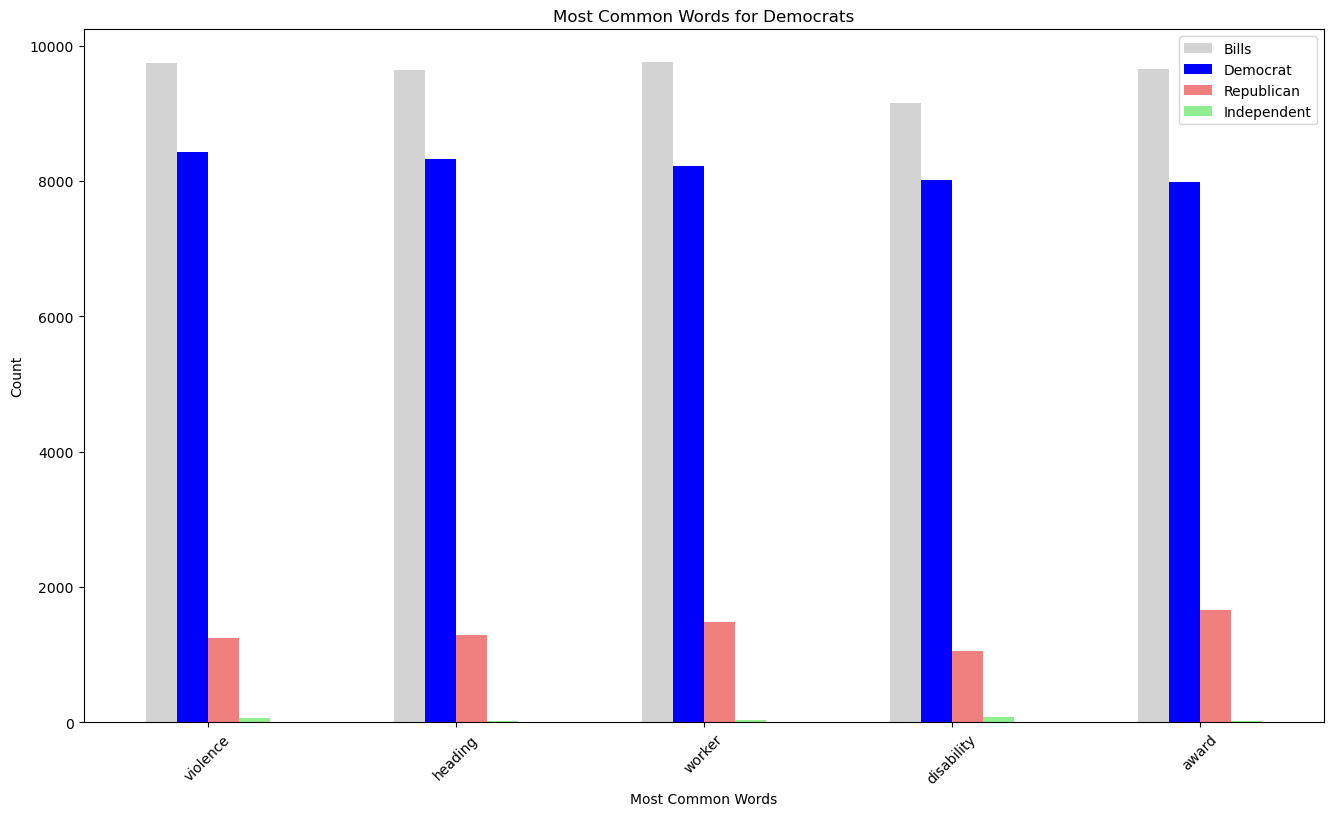

In [230]:
democrat = demo_vis(word_freq)

In [239]:
def repub_vis(word_freq):
    '''
    This function creates a bar plot of the most common words appearing for republicans.
    '''
    
    #Plot the most frequent democratic words and color by label
    ax = word_freq.sort_values('repub', ascending=False).head(5).plot.bar(color=['lightgrey', 'aliceblue', 'red', 'lightgreen'], figsize=(16, 9))
    ax.grid(True, axis='x', color='white')
    plt.title('Most Common Words for Republicans')
    plt.ylabel('Count')
    plt.xlabel('Most Common Words')
    plt.xticks(rotation=45)
    ax.legend(['Bills', 'Democrat', 'Republican', 'Independent'])
    return plt.show()

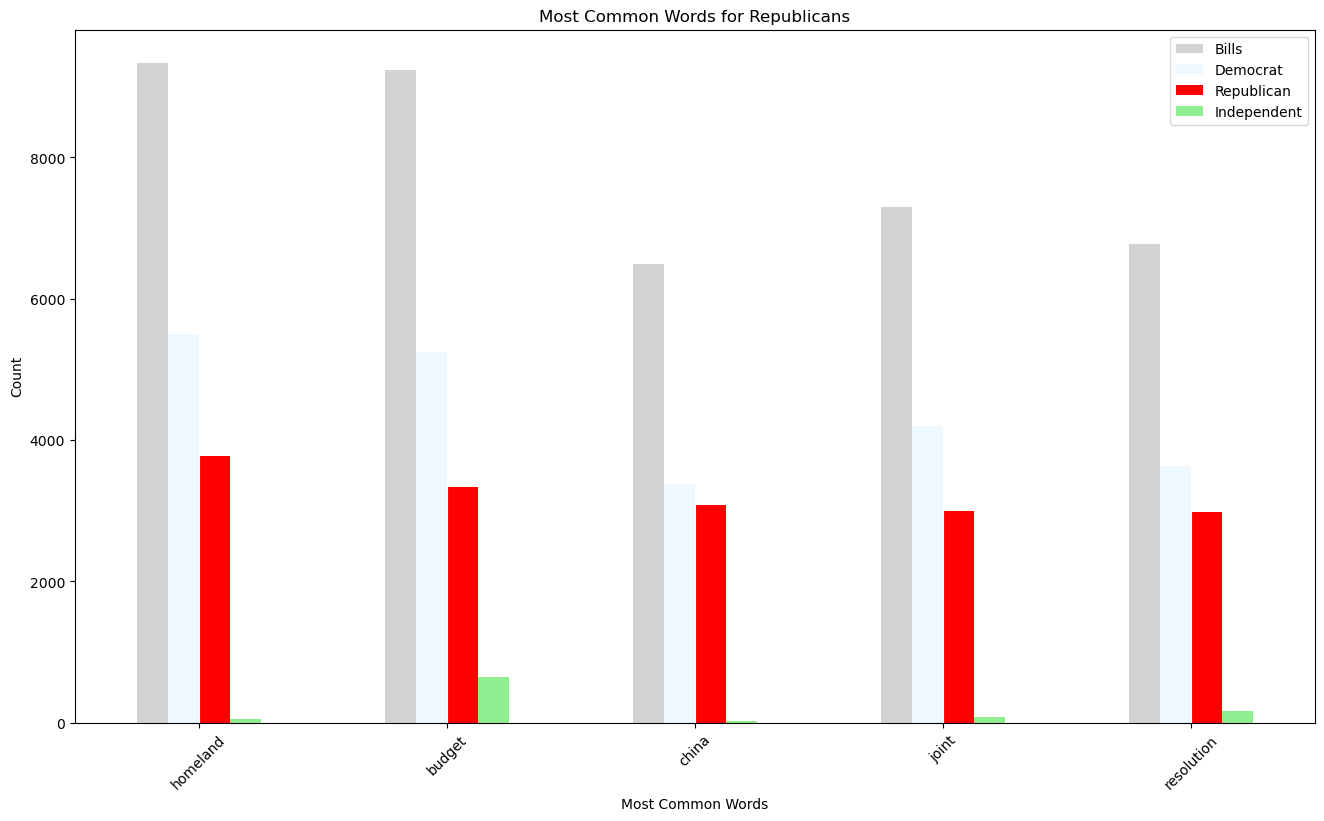

In [240]:
republican = repub_vis(word_freq)

In [ ]:
def ind_vis(word_freq):
    '''
    This function creates a bar plot of the most common words appearing for democrats.
    '''
    
    #Plot the most frequent independent words and color by label
    #x = np.linspace(1, 10, 10)
    ax = word_freq.sort_values('ind', ascending=False).head(5).plot.bar(color=['lightgrey', 'aliceblue', 'lightcoral', 'green'], edgecolor=['black'], linewidth=3, figsize=(10, 10))
    plt.title('Most Common Words for Independents')
    plt.ylabel('Count')
    plt.xlabel('Most Common Words')
    plt.xticks(rotation=45)
    ax.legend(['Bills', 'Democrat', 'Republican', 'Independent'])
    return plt.show()

In [189]:
def bill_vis(word_freq):
    '''
    This function creates a bar plot of the most common words appearing for democrats.
    '''
    
    #Plot the most frequent democratic words and color by label
    ax = word_freq.sort_values('bills', ascending=False).head(5).plot.bar(color=['lightgrey', 'royalblue', 'red', 'green'], figsize=(16, 9))
    plt.title('Most Common Words for all Bills')
    plt.ylabel('Count')
    plt.xlabel('Most Common Words')
    plt.xticks(rotation=45)
    #plt.legend(legend_handles, ['Bills','Democrat','Republican', 'Independent']
    ax.legend(['Bills', 'Democrat', 'Republican', 'Independent'])
    return plt.show()

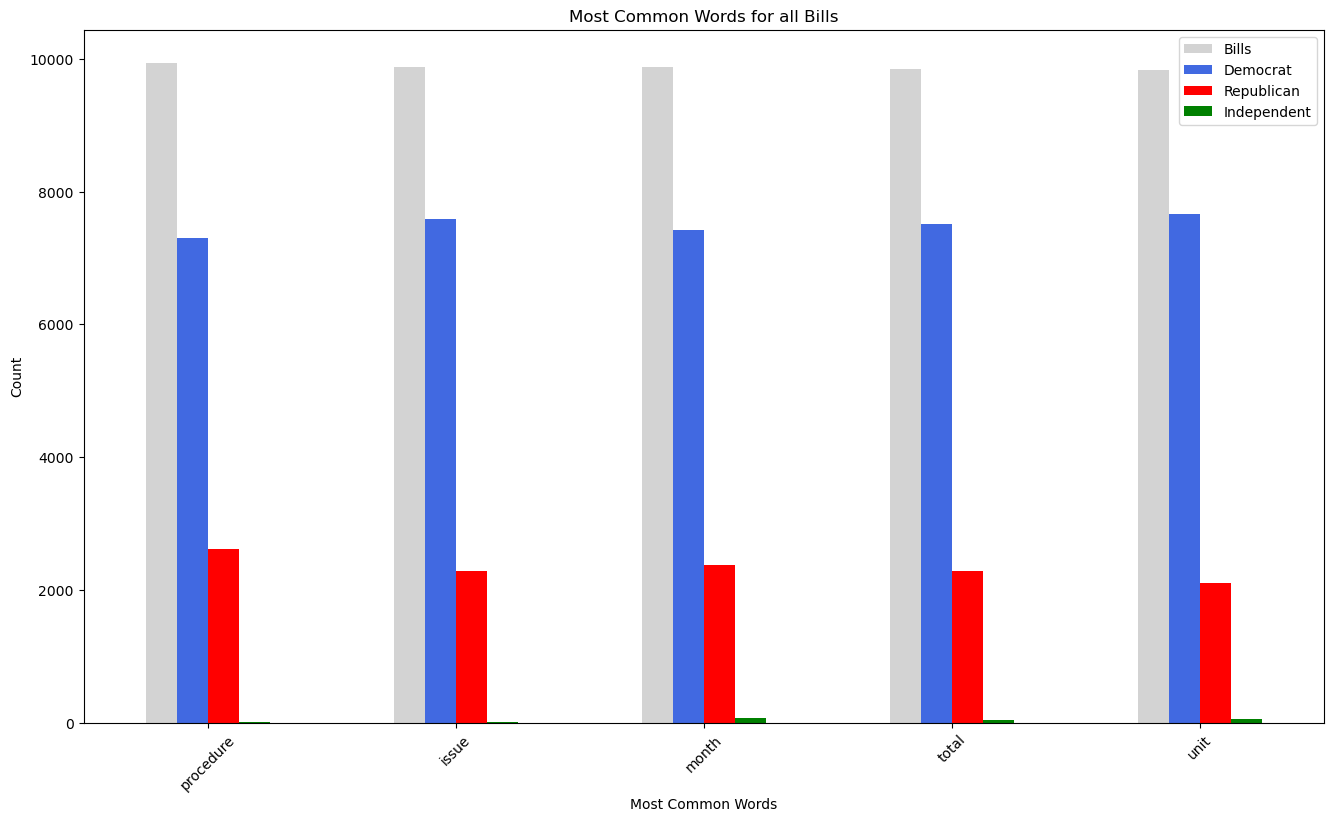

In [190]:
bills = bill_vis(word_freq)

In [165]:
more_stopwords = ['secretary','united','states','senate','house','representative',
                   'representatives','fiscal','year','shall','adding','end','paragraph',
                   'made','available','prebody','subsection','day','date','submit','described',
                   'may','congress','following','new','enactment','code','section','assembled',
                   'b','amended','short','title','sec','heading', 'et', 'seq',
                    'chapter', 'effective','enacted','subchapter','entity', '42', 'usc', 'act', 'establish', 'categorical', 'america', '1', '2', 'seq']

In [152]:
ind_words = clean_text(' '.join(df[df['party'] == 'I']['bill_text']), more_stopwords)

In [153]:
ind_bigrams = pd.Series(nltk.ngrams(ind_words, 2))
ind_bigrams

0                (improve, global)
1                 (global, health)
2               (health, security)
3              (security, purpose)
4                 (purpose, cited)
                    ...           
128756        (entered, withdrawn)
128757      (withdrawn, warehouse)
128758    (warehouse, consumption)
128759         (consumption, 15th)
128760             (15th, ltallgt)
Length: 128761, dtype: object

In [154]:
top_ind_bigrams = ind_bigrams.value_counts().head(10)
top_ind_bigrams

(budget, authority)           490
(social, security)            302
(trust, fund)                 254
(internal, revenue)           248
(health, care)                218
(revenue, 1986)               216
(critical, infrastructure)    162
(item, service)               135
(datethe, amendment)          116
(natural, gas)                113
dtype: int64

In [155]:
repub_words = clean_text(' '.join(df[df['party'] == 'R']['bill_text']), more_stopwords)

In [156]:
repub_bigrams = pd.Series(nltk.ngrams(repub_words, 2))
repub_bigrams

0             (exclusion, electric)
1               (electric, utility)
2               (utility, rightsof)
3                   (rightsof, way)
4                    (way, purpose)
                     ...           
6120769        (entered, withdrawn)
6120770      (withdrawn, warehouse)
6120771    (warehouse, consumption)
6120772         (consumption, 15th)
6120773             (15th, ltallgt)
Length: 6120774, dtype: object

In [157]:
top_repub_bigrams = repub_bigrams.value_counts().head(10)
top_repub_bigrams

(homeland, security)    7261
(public, health)        4748
(public, law)           4734
(law, enforcement)      4597
(health, care)          4431
(social, security)      4428
(purpose, cited)        4368
(federal, agency)       4355
(internal, revenue)     4288
(state, local)          4054
dtype: int64

In [158]:
demo_words = clean_text(' '.join(df[df['party'] == 'D']['bill_text']), more_stopwords)

In [159]:
demo_bigrams = pd.Series(nltk.ngrams(demo_words, 2))
demo_bigrams

0                (require, homeland)
1               (homeland, security)
2                (security, develop)
3                    (develop, plan)
4                   (plan, increase)
                      ...           
18696438        (entered, withdrawn)
18696439      (withdrawn, warehouse)
18696440    (warehouse, consumption)
18696441         (consumption, 15th)
18696442             (15th, ltallgt)
Length: 18696443, dtype: object

In [160]:
top_demo_bigrams = demo_bigrams.value_counts().head(10)
top_demo_bigrams

(public, health)       18006
(health, care)         15889
(higher, education)    14352
(state, local)         13765
(public, law)          13666
(indian, tribe)        12675
(social, security)     12578
(meaning, given)       12423
(given, term)          12230
(law, enforcement)     10843
dtype: int64

In [166]:
bill_words = clean_text(' '.join(df['bill_text']), more_stopwords)

In [167]:
bill_bigrams = pd.Series(nltk.ngrams(bill_words, 2))
bill_bigrams

0                (require, homeland)
1               (homeland, security)
2                (security, develop)
3                    (develop, plan)
4                   (plan, increase)
                      ...           
24950136        (entered, withdrawn)
24950137      (withdrawn, warehouse)
24950138    (warehouse, consumption)
24950139         (consumption, 15th)
24950140             (15th, ltallgt)
Length: 24950141, dtype: object

In [168]:
top_bill_bigrams = bill_bigrams.value_counts().head(10)
top_bill_bigrams

(public, health)        22856
(health, care)          20538
(public, law)           18478
(state, local)          17869
(higher, education)     17493
(social, security)      17308
(homeland, security)    16395
(meaning, given)        16092
(given, term)           15868
(law, enforcement)      15465
dtype: int64

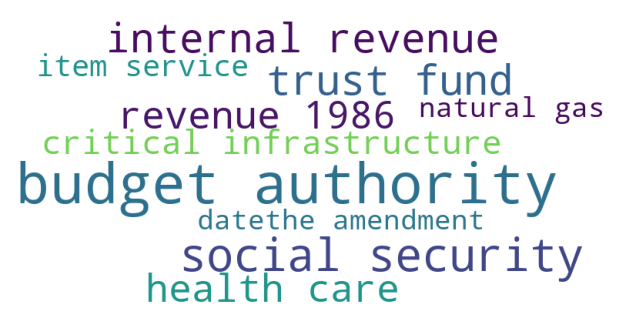

In [169]:
#Word cloud for top independent bigrams words
data = {k[0] + ' ' + k[1]: v for k, v in top_ind_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

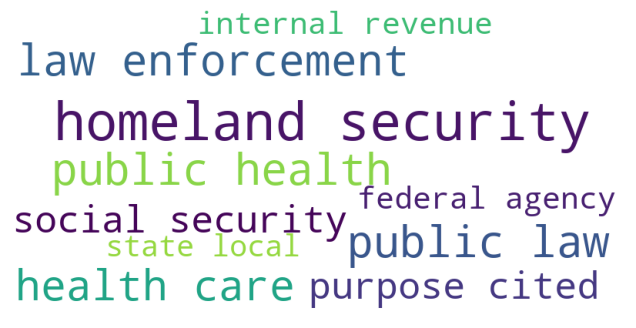

In [170]:
#Word cloud for top republican words
data = {k[0] + ' ' + k[1]: v for k, v in top_repub_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

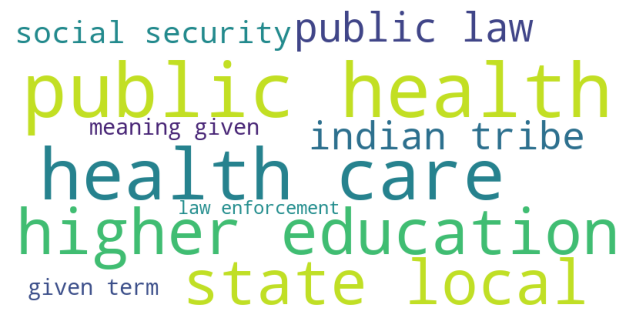

In [171]:
#Word cloud for top democrat words
data = {k[0] + ' ' + k[1]: v for k, v in top_demo_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

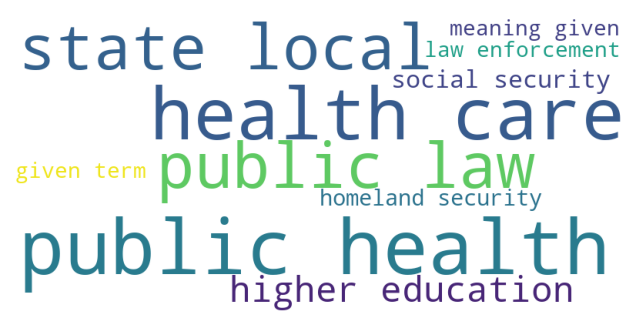

In [172]:
#Word cloud for top bigrams words
data = {k[0] + ' ' + k[1]: v for k, v in top_bill_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [173]:
ind_trigrams = pd.Series(nltk.ngrams(ind_words, 3))
ind_trigrams

0                   (improve, global, health)
1                  (global, health, security)
2                 (health, security, purpose)
3                  (security, purpose, cited)
4                    (purpose, cited, global)
                         ...                 
128755             (good, entered, withdrawn)
128756        (entered, withdrawn, warehouse)
128757    (withdrawn, warehouse, consumption)
128758         (warehouse, consumption, 15th)
128759           (consumption, 15th, ltallgt)
Length: 128760, dtype: object

In [174]:
top_ind_trigrams = ind_trigrams.value_counts().head(10)
top_ind_trigrams

(internal, revenue, 1986)                216
(insurance, trust, fund)                 101
(datethe, amendment, apply)               89
(meaning, given, term)                    81
(oil, natural, gas)                       79
(institution, higher, education)          73
(behavioral, health, care)                69
(systemically, important, critical)       67
(health, human, service)                  64
(important, critical, infrastructure)     63
dtype: int64

In [175]:
repub_trigrams = pd.Series(nltk.ngrams(repub_words, 3))
repub_trigrams

0               (exclusion, electric, utility)
1                (electric, utility, rightsof)
2                     (utility, rightsof, way)
3                     (rightsof, way, purpose)
4                        (way, purpose, cited)
                          ...                 
6120768             (good, entered, withdrawn)
6120769        (entered, withdrawn, warehouse)
6120770    (withdrawn, warehouse, consumption)
6120771         (warehouse, consumption, 15th)
6120772           (consumption, 15th, ltallgt)
Length: 6120773, dtype: object

In [176]:
top_repub_trigrams = repub_trigrams.value_counts().head(10)
top_repub_trigrams

(internal, revenue, 1986)                  3595
(people, republic, china)                  3559
(meaning, given, term)                     3542
(health, human, service)                   2539
(public, health, service)                  2175
(later, 180, day)                          2082
(appropriate, congressional, committee)    2008
(institution, higher, education)           1828
(immigration, nationality, 8)              1664
(inserting, numerical, sequence)           1605
dtype: int64

In [177]:
demo_trigrams = pd.Series(nltk.ngrams(demo_words, 3))
demo_trigrams

0                 (require, homeland, security)
1                 (homeland, security, develop)
2                     (security, develop, plan)
3                     (develop, plan, increase)
4                         (plan, increase, 100)
                           ...                 
18696437             (good, entered, withdrawn)
18696438        (entered, withdrawn, warehouse)
18696439    (withdrawn, warehouse, consumption)
18696440         (warehouse, consumption, 15th)
18696441           (consumption, 15th, ltallgt)
Length: 18696442, dtype: object

In [178]:
top_demo_trigrams = demo_trigrams.value_counts().head(10)
top_demo_trigrams

(meaning, given, term)                     12207
(internal, revenue, 1986)                   9342
(health, human, service)                    8950
(institution, higher, education)            8451
(public, health, service)                   6525
(later, 180, day)                           5683
(education, 1965, 20)                       5571
(local, educational, agency)                5037
(higher, education, 1965)                   4734
(appropriate, congressional, committee)     4159
dtype: int64

In [179]:
bill_trigrams = pd.Series(nltk.ngrams(bill_words, 3))
bill_trigrams

0                 (require, homeland, security)
1                 (homeland, security, develop)
2                     (security, develop, plan)
3                     (develop, plan, increase)
4                         (plan, increase, 100)
                           ...                 
24950135             (good, entered, withdrawn)
24950136        (entered, withdrawn, warehouse)
24950137    (withdrawn, warehouse, consumption)
24950138         (warehouse, consumption, 15th)
24950139           (consumption, 15th, ltallgt)
Length: 24950140, dtype: object

In [180]:
top_bill_trigrams = bill_trigrams.value_counts().head(10)
top_bill_trigrams

(meaning, given, term)                     15831
(internal, revenue, 1986)                  13153
(health, human, service)                   11559
(institution, higher, education)           10352
(public, health, service)                   8746
(later, 180, day)                           7798
(education, 1965, 20)                       6704
(local, educational, agency)                6464
(people, republic, china)                   6281
(appropriate, congressional, committee)     6185
dtype: int64

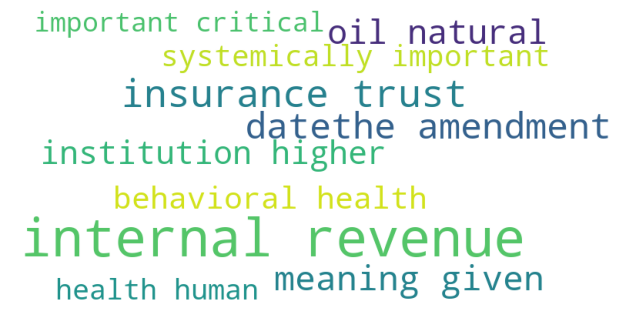

In [181]:
#Word cloud for top independent trigrams words
data = {k[0] + ' ' + k[1]: v for k, v in top_ind_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

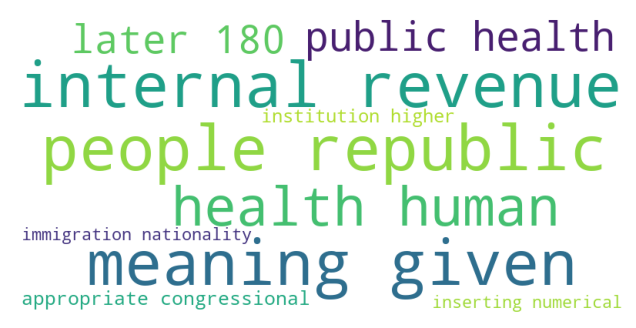

In [182]:
#Word cloud for top republican trigrams words
data = {k[0] + ' ' + k[1]: v for k, v in top_repub_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

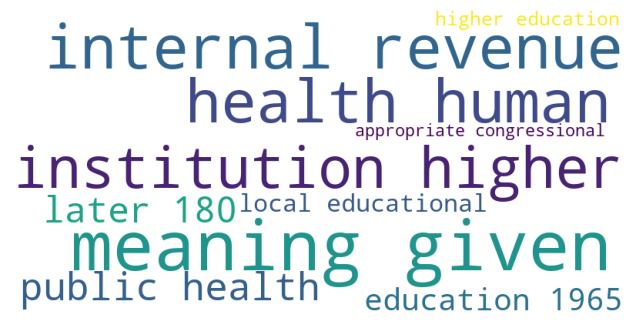

In [183]:
#Word cloud for top democrat trigrams words
data = {k[0] + ' ' + k[1]: v for k, v in top_demo_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

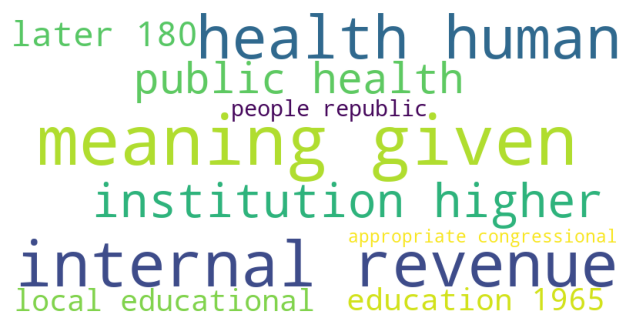

In [184]:
#Word cloud for top trigrams words
data = {k[0] + ' ' + k[1]: v for k, v in top_bill_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [196]:
#Plot independent trigrams
def ind_trigrams_vis(df):
    top_ind_trigrams.plot.barh().invert_yaxis()
    plt.xlabel('Count')
    plt.ylabel('Trigrams')
    plt.title('Commonly occurring independent trigrams')
    return plt.show()

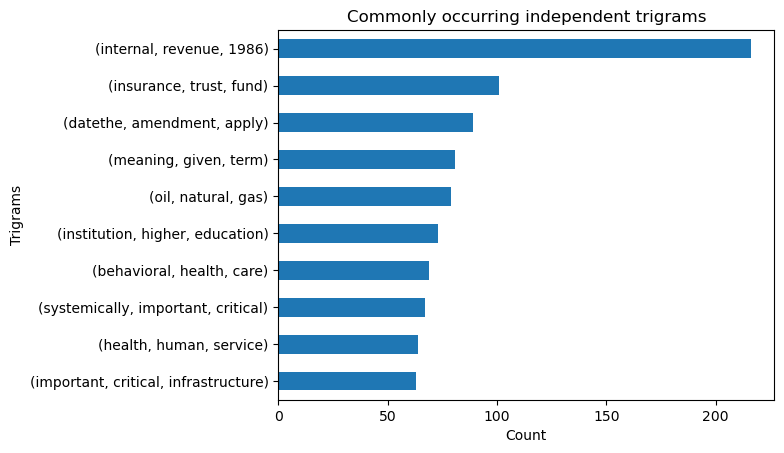

In [241]:
ind_trigrams_bar = ind_trigrams_vis(word_freq)

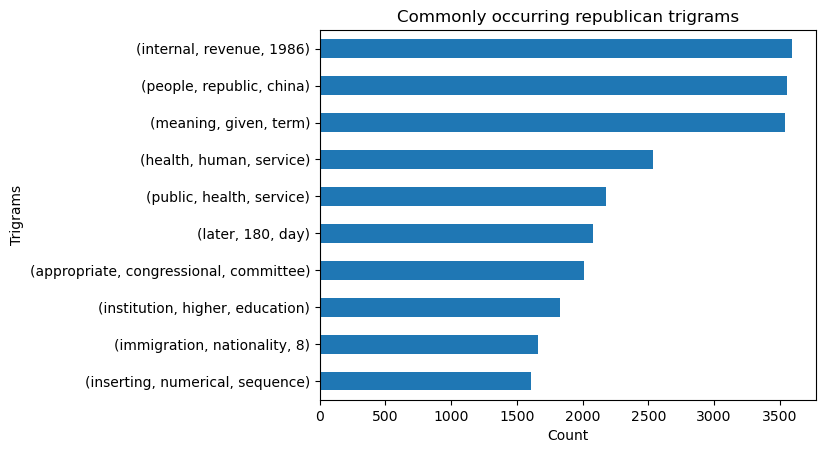

In [186]:
#Plot republican trigrams
top_repub_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigrams')
plt.title('Commonly occurring republican trigrams')
plt.show()

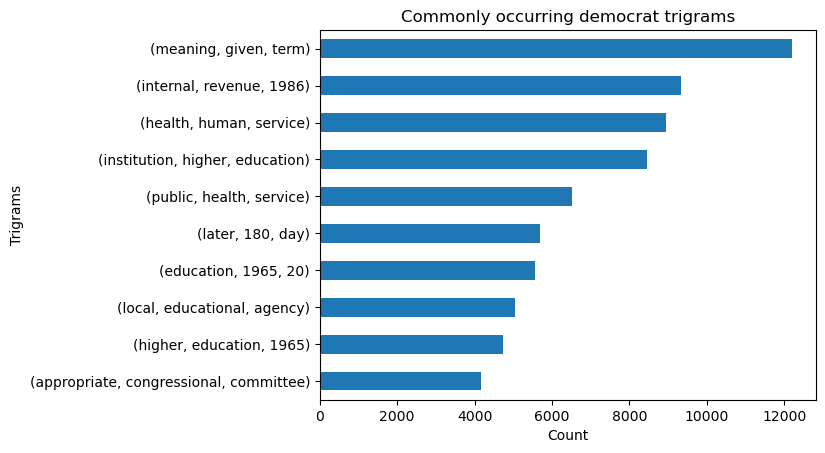

In [187]:
#Plot democrat trigrams
top_demo_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigrams')
plt.title('Commonly occurring democrat trigrams')
plt.show()

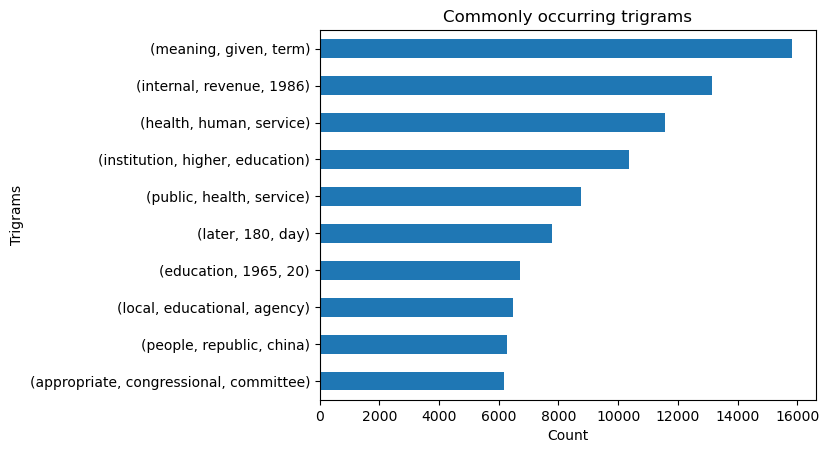

In [188]:
#Plot all trigrams
top_bill_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigrams')
plt.title('Commonly occurring trigrams')
plt.show()

# 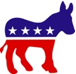